<a href="https://colab.research.google.com/github/Vmjkom/Deep-learning-nlp/blob/master/Finbert_vs_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gzip -dv  /content/drive/MyDrive/Kandi/Aineisto/COMBINED-COARSE-SENTIMENT-140321.tsv.gz

/content/drive/MyDrive/Kandi/Aineisto/COMBINED-COARSE-SENTIMENT-140321.tsv.gz:	 63.1% -- replaced with /content/drive/MyDrive/Kandi/Aineisto/COMBINED-COARSE-SENTIMENT-140321.tsv


PIP INSTALLS

In [ ]:
!pip --quiet install datasets transformers optuna captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 123.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 KB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

IMPORTS

In [ ]:
import csv #To open and deserialize the tsv file
import seaborn as sb #Plots, graphs
import matplotlib.pyplot as plt #Plots, more hardcore than seaborn
import pandas as pd
from datasets import ClassLabel, Value, Dataset, Features, DatasetDict,load_metric #Huggingface dataset libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer,DataCollatorWithPadding #Hugginface libraries for transformer based models
import gc #Pythons garbage collection
import torch #Pytorch
import numpy as np
import re #Python regex for string handling

#Sklearn for naive bayes baseline model
from sklearn.model_selection import train_test_split 
from sklearn.naive_bayes import ComplementNB
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.metrics

#Captum stuff
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer



In [ ]:
!wc -l /content/drive/MyDrive/Kandi/Aineisto/COMBINED-COARSE-SENTIMENT-140321.tsv
!head -n 20 /content/drive/MyDrive/Kandi/Aineisto/COMBINED-COARSE-SENTIMENT-140321.tsv

24826 /content/drive/MyDrive/Kandi/Aineisto/COMBINED-COARSE-SENTIMENT-140321.tsv
ID	text	majority
review-100217.1	"Annassa Donner tuntuu palanneen lähemmäksi ensimmäisten elokuviensa tyyliä", pohjusti Sakari Toiviainen (Ilta-Sanomat 24.10.1970), "maailmaa jonka ihmiset ja tunnelmat ovat kaikua jonkun Antonionin tai Bergmanin sisäistyneestä tavasta kertoa ihmisen yksinäisyydestä, elämän tyhjyydestä ja puuttuvasta yhteydestä ympäristöön.	other
review-100217.2	Tavoitteet näyttävät siis 'kunnianhimoisemmilta' ja 'taiteellisemmilta' kuin Sixtyninessa tai Naisenkuvissa.	positive
review-100217.3	Arvostelijat voivat huokaista helpotuksesta ja todeta hyvällä omallatunnolla, että tuhlaajapoika on palannut takaisin ja ruvennut taas käsittelemään 'vakavia' ja 'keskeisiä' ongelmia."	other
review-100217.6	"Teema on mielenkiintoinen paperilla, ja hyvin kirjallinen", koki Heikki Eteläpää (Uusi Suomi 25.10.1970), "elokuvana siitä tulisi mielenkiintoinen, siitä voisi tulla järkyttävä tragedia, jos pysty

# Data import
Import the tsv data and turn it into a python dictionairy.

Only include the Text and Majority(labels) columns.

In [ ]:

with open("/content/drive/MyDrive/Kandi/Aineisto/COMBINED-COARSE-SENTIMENT-140321.tsv") as file:
  next(file) #skip header
  data = [l.split('\t') for l in file]

  texts = [l[1] for l in  data]
  labels = [l[2].strip() for l in data]
  #Replace english label names with finnish equivelants
  labels = [l.replace("positive","positiivinen") for l in labels]
  labels = [l.replace("other","muu") for l in labels]
  labels = [l.replace("negative","negatiivinen") for l in labels]
  labels = [l.replace("neutral","neutraali") for l in labels]

  test = list(zip(labels,texts))

dicti = {'luokka': labels, 'teksti':texts}


# Inspect the data


<Axes: xlabel='luokka', ylabel='Määrä'>

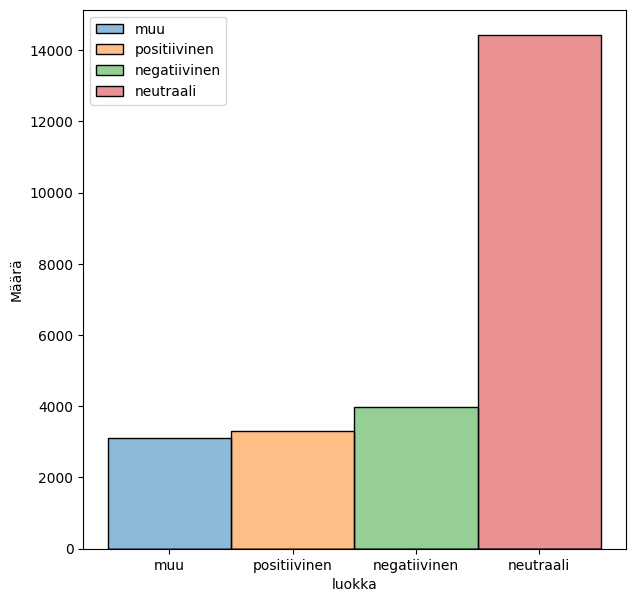

In [ ]:
plt.figure(figsize=(7,7))
per = sb.histplot(data=dicti,x='luokka',hue=dicti['luokka'],stat='count')
per.set(ylabel='Määrä')
per

<Axes: xlabel='luokka', ylabel='Prosenttiosuus'>

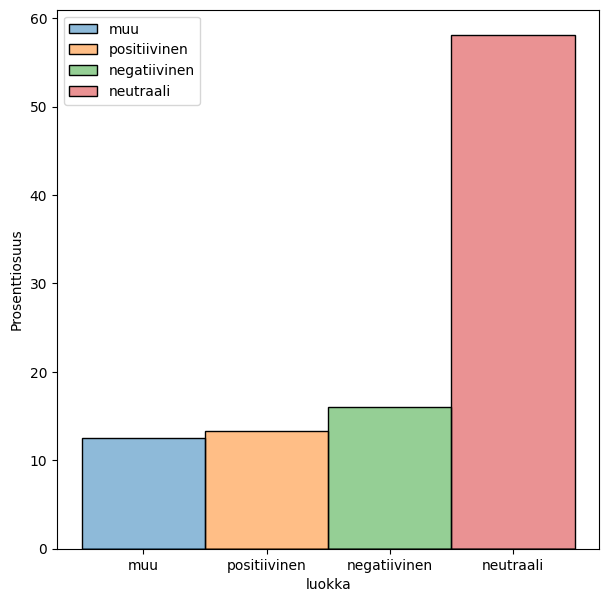

In [ ]:
plt.figure(figsize=(7,7))
per = sb.histplot(data=dicti,x='luokka',hue=dicti['luokka'],stat='percent'
)
per.set(ylabel='Prosenttiosuus')
per

# Turn data into transformers dataset

https://huggingface.co/docs/datasets/index 

In [ ]:
classnames = tuple(set(labels))#Majority labels: neutral, negative, positive, other
print("Labels for majority: ")
for name in classnames:
  print(name)

dataset_features = Features({'teksti': Value('string'), 'luokka': ClassLabel(names=classnames)})
dataset = Dataset.from_dict(dicti,features=dataset_features)


print("features, for the dataset,", dataset.features)

Labels for majority: 
positiivinen
neutraali
muu
negatiivinen
features, for the dataset, {'luokka': ClassLabel(names=('positiivinen', 'neutraali', 'muu', 'negatiivinen'), id=None), 'teksti': Value(dtype='string', id=None)}


In [ ]:
train_data = dataset.train_test_split(test_size=0.2,shuffle=True,seed=123) #Split into train, and development
test_data = train_data['test'].train_test_split(test_size=0.5,seed=123) #Split the train split from above to test, that wont be used in training 
dataDict = DatasetDict({
    'train': train_data['train'],
    'development': test_data['test'],
    'test': test_data['train']
})
dataDict

DatasetDict({
    train: Dataset({
        features: ['luokka', 'teksti'],
        num_rows: 19860
    })
    development: Dataset({
        features: ['luokka', 'teksti'],
        num_rows: 2483
    })
    test: Dataset({
        features: ['luokka', 'teksti'],
        num_rows: 2482
    })
})

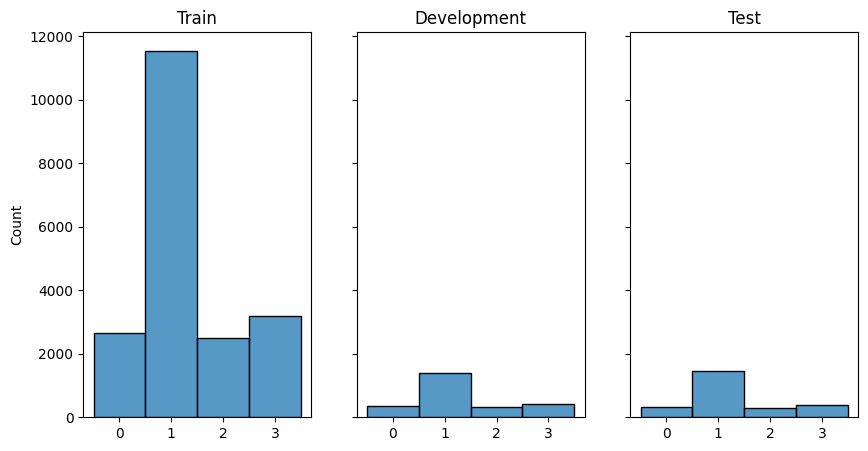

In [ ]:

fig, axes  = plt.subplots(1,3, figsize=(10, 5), sharey=True)
fig.suptitle("")
sb.histplot(ax=axes[0], data=dataDict['train']['luokka'], discrete=True)
sb.histplot(ax=axes[1], data=dataDict['development']['luokka'], discrete=True)
sb.histplot(ax=axes[2], data=dataDict['test']['luokka'], discrete=True)

axes[0].set_title("Train")
axes[1].set_title("Development")
axes[2].set_title("Test");

In [ ]:
label2id = {}
for i,x in enumerate(dataset.features['luokka'].names):
  label2id[x] = i
id2label = {v: k for k,v in label2id.items()}

In [ ]:
print(label2id)
print(id2label)

{'positiivinen': 0, 'neutraali': 1, 'muu': 2, 'negatiivinen': 3}
{0: 'positiivinen', 1: 'neutraali', 2: 'muu', 3: 'negatiivinen'}


Import the finnish bert cased model and the tokenizer for it. 
Encode the data, with truncation enabled.

# Tokenize

In [ ]:

MODEL_NAME = "TurkuNLP/bert-base-finnish-cased-v1"

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=len(classnames),label2id=label2id,
                                                           id2label=id2label)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.max_model_input_sizes[MODEL_NAME]



Some weights of the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the m

512

In [ ]:
#Tokenize the data
def tokenize(d):
  return(
      tokenizer(d['teksti'],
      truncation=True,
      padding=True,
      )
  )

encoded_data = dataDict.map(tokenize)
encoded_data

Map:   0%|          | 0/19860 [00:00<?, ? examples/s]

Map:   0%|          | 0/2483 [00:00<?, ? examples/s]

Map:   0%|          | 0/2482 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['luokka', 'teksti', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 19860
    })
    development: Dataset({
        features: ['luokka', 'teksti', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2483
    })
    test: Dataset({
        features: ['luokka', 'teksti', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2482
    })
})

In [ ]:
toy_seq = dicti['teksti'][10]

# The length of the input must match the size of the input layer of BERT we are about to use. In our case it is 512.
print(f"Maximum input size of{MODEL_NAME} model: {tokenizer.max_model_input_sizes[MODEL_NAME]}")

# If we do not hit the limit of the model input size when truncation is on, max_length sets the length of the tokenized input. 
max_tokens = len(toy_seq)

#tokenized = tokenizer.tokenize(toy_seq, truncation= True, padding = True, max_length = max_tokens) 
input=tokenizer(toy_seq, truncation= True, padding = True, max_length = max_tokens)
print(f"Plain toy input: {toy_seq}")
print(f"Truncated (first {max_tokens}) tokens: {input}")
print(f"Human readable input: {tokenizer.decode(tokenizer(toy_seq, truncation= True, padding = True, max_length = max_tokens)['input_ids'])}") 
# decode the input indices back to text. Compulsory [CLS] and [SEP] tokens are part of the input. They have fixed ids.
print("Model input:")
for key, value in input.items():
  print(key, value)

Maximum input size ofTurkuNLP/bert-base-finnish-cased-v1 model: 512
Plain toy input: "Se on ulkokohtainen, elegantti ja pitkästyttävä", luonnehti puolestaan Erkka Lehtola (Aamulehti 25.10.1970).
Truncated (first 109) tokens: {'input_ids': [102, 245, 577, 145, 912, 19705, 119, 26943, 2005, 428, 142, 1441, 1388, 3877, 245, 119, 14588, 3052, 45565, 11659, 255, 348, 36404, 2197, 111, 1091, 111, 10052, 308, 111, 103], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
Human readable input: [CLS] " Se on ulkokohtainen, elegantti ja pitkästyttävä ", luonnehti puolestaan Erkka Lehtola ( Aamulehti 25. 10. 1970 ). [SEP]
Model input:
input_ids [102, 245, 577, 145, 912, 19705, 119, 26943, 2005, 428, 142, 1441, 1388, 3877, 245, 119, 14588, 3052, 45565, 11659, 255, 348, 36404, 2197, 111, 1091, 111, 10052, 308, 111, 103]
token_t

In [ ]:
lens = [len(input) for input in encoded_data['train']['input_ids']]
lens.sort(reverse=True)
print(lens[:10]) # longest inputs have length of 512

SyntaxError: ignored

# Training arguments, compute metrics

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)

    accuracy = load_metric("accuracy")
    f1 = load_metric("f1")
    recall = load_metric('recall')
    precision = load_metric('precision')

    accuracy = accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = f1.compute(predictions=predictions, references=labels,average='weighted')["f1"]
    return {"accuracy": accuracy, "f1": f1}
    
data_collator = DataCollatorWithPadding(tokenizer)

args = TrainingArguments(
    output_dir = "/content/drive/MyDrive/Kandi/Malli",
    overwrite_output_dir = True,
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    fp16=True,
    save_strategy = 'epoch',
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    optim='adafactor'
)

#Needed customised callback for the hyperparameter search
"""class my_callback(TrainerCallback):

  def on_train_begin(self,args,state,control,**kwargs):
    utils.logging.set_verbosity(40) # Reduce the amount of info logging on training loop
  def on_train_end(self, args, state, control,**kwargs):
    #Carbage collect and remove model checkpoint folders after every train loop to save disk space
    gc.collect()
    
    %%rm -rf output_dir"""

"""Search space for the hyperparameter search. These values are small enough so the search doesnt run into oom problems on the gpu"""
def my_hp_space(trial):
  
    return {
        "optimizer": trial.suggest_categorical("optimizer", ["Adam"]),
        "learning_rate": trial.suggest_float("learning_rate", 2e-5, 5e-5, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs",3, 5),
        "seed": trial.suggest_int("seed", 1, 40),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [10, 16, 32]),
    }


def my_objective(metrics):
    """Metric to be maximized during the hyperparamete search"""
    
    return metrics['eval_accuracy']

"""def model_init():
  #Hyperparameter search needs the model to be inputted trough a function
  utils.logging.set_verbosity(40)
  return AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=4)
"""

'def model_init():\n  #Hyperparameter search needs the model to be inputted trough a function\n  utils.logging.set_verbosity(40)\n  return AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=4)\n'

# Train the model

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_data['train'],
    eval_dataset=encoded_data['development'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

Using cuda_amp half precision backend


In [ ]:
trainer.train()

In [ ]:
results = trainer.evaluate()
for v,k in results.items():
  print(v,k)

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2483
  Batch size = 8


eval_loss 0.6254138350486755
eval_accuracy 0.7829238824003222
eval_f1 0.778777856219582
eval_runtime 5.5448
eval_samples_per_second 447.81
eval_steps_per_second 56.089
epoch 3.0


In [ ]:
predictions_finBert = trainer.predict(encoded_data['test'])

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2482
  Batch size = 8


In [ ]:
model.save_pretrained('/content/drive/MyDrive/Kandi/Malli')

Configuration saved in /content/drive/MyDrive/Kandi/Malli/config.json
Model weights saved in /content/drive/MyDrive/Kandi/Malli/pytorch_model.bin


In [ ]:
predictions_finBert.metrics

{'test_loss': 0.6272678971290588,
 'test_accuracy': 0.7816277195809831,
 'test_f1': 0.7794536379470962,
 'test_runtime': 7.0372,
 'test_samples_per_second': 352.698,
 'test_steps_per_second': 44.194}

#FINBERT predictions
#TODO
Katso mitkä lauseet ennustettiin väärin
Mikä kategoria eniten väärin ennustettu, mikä oikein
Ota talteen muutama väärin ennustettu lause ja käytä captumia näiden havannointiin

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/Kandi/Malli')

In [ ]:
temp = list(zip(list(predictions_finBert.label_ids),encoded_data['test']['label'])) # predictions vs true label

# FinBert vs Naive Bayes

In [ ]:

#Taken from https://towardsdatascience.com/cleaning-text-data-with-python-b69b47b97b76

def text_clean(x):

    x = re.sub(r'https*\S+', ' ', x) # remove links
    x = re.sub(r'http*\S+', ' ', x)
    x = re.sub("@\S+", " ", x) # remove mentions
    x = re.sub("#\S+", " ", x) #Remove hashtags

    x = re.sub(r'\w*\d+\w*', '', x) 
    x = re.sub(r'\s{2,}', ' ', x) #Remove unneccessary spaces
    x = re.sub(r'\s[^\w\s]\s', '', x)
    return x


In [ ]:

def pre_process(train,test):

  train,test =  train.to_dict(), test.to_dict()

  vectorizer = TfidfVectorizer()

  train_text,test_text = train['text'],test['text']
  train_labels,test_labels = train['label'], test['label']

  train_text = [text_clean(line) for line in train_text]
  test_text = [text_clean(line) for line in test_text]
  
  train_text = vectorizer.fit_transform(train_text)
  test_text = vectorizer.transform(test_text)

  return train_text,train_labels,test_text,test_labels

classifier = ComplementNB()
train_data,train_labels,test_text,test_labels = pre_process(dataDict['train'],dataDict['test'])
classifier.fit(train_data,train_labels)

ComplementNB()

In [ ]:
predictions_nb = classifier.predict(test_text)
print("Accuracy",sklearn.metrics.accuracy_score(test_labels,predictions_nb))
print("F1 score",sklearn.metrics.f1_score(test_labels,predictions_nb,average='weighted'))

Accuracy 0.6059629331184528
F1 score 0.5743569684845446


In [ ]:
predictions_finBert

# Captum

In [ ]:
model.to('cpu')
#Tells the model that it is in evaluation mode, and zeroes out the gradients

model.eval()
model.zero_grad()

In [ ]:
# Forward on the model -> data in, prediction out, nothing fancy really
def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    pred=model(inputs, token_type_ids=token_type_ids,
                 position_ids=position_ids, attention_mask=attention_mask)
    return pred.logits

ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [ ]:
predictins_test_data=map()

In [ ]:
def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id, device):
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id] #the standard way of feeding the input in

    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]  #basically [CLS] [PAD] [PAD] [PAD] ... [SEP] ... blank
    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device)


def construct_input_ref_token_type_pair(input_ids, device):
    seq_len = input_ids.size(1)
    token_type_ids = torch.zeros((1,seq_len), dtype=torch.long, device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids, device):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    #make sure shapes match
    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids

def construct_attention_mask(input_ids,device):
  return torch.ones_like(input_ids,device=device)

In [ ]:
lig = LayerIntegratedGradients(predict, model.bert.embeddings)

In [ ]:
device=model.device

text="Minä vihaan itseäni, rakastan muita"

#input:
input_ids, ref_input_ids = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id, device)
#token type:
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, device)
#position ids:
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids, device)
#attention mask:
attention_mask = construct_attention_mask(input_ids, device)

all_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print(all_tokens)

['[CLS]', 'Minä', 'vihaan', 'itseäni', ',', 'rakastan', 'muita', '[SEP]']


In [ ]:
p=predict(input_ids,token_type_ids=token_type_ids,position_ids=position_ids,attention_mask=attention_mask)
print("p=",p)
print("p.shape",p.shape)

p= tensor([[-0.3331, -0.3122, -0.0769,  1.7038]], grad_fn=<AddmmBackward0>)
p.shape torch.Size([1, 4])


In [ ]:
attrs, delta = lig.attribute(inputs=(input_ids,token_type_ids,position_ids,attention_mask),
                                  baselines=(ref_input_ids,ref_token_type_ids,ref_position_ids,attention_mask),
                                  return_convergence_delta=True,target=model.config.label2id['positive'])

In [ ]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)#Hidden states aka bertembeddingslayer
    
    attributions = attributions / torch.norm(attributions)
    
    return attributions



In [ ]:
attrs_sum = summarize_attributions(attrs)
for a,t in zip(attrs_sum,tokenizer.convert_ids_to_tokens(input_ids[0])):
    print(float(a),t)

0.0 [CLS]
-0.3893767052691818 Minä
-0.25414905812025956 vihaan
-0.24483335117797864 itseäni
0.038138102092513684 ,
0.8065957223233685 rakastan
0.12591134717984753 muita
-0.236528700903384 [SEP]


In [ ]:
attrs_sum = summarize_attributions(attrs)
import captum
from IPython.core.display import HTML, display
x=captum.attr.visualization.format_word_importances(tokenizer.convert_ids_to_tokens(input_ids[0]),attrs_sum)
HTML(x)

In [ ]:
from IPython.core.display import HTML, display
vis_data_records = []

def predict_line(line):
  lig = LayerIntegratedGradients(predict, model.bert.embeddings)
  model.zero_grad()
  device = model.device

  #input:
  input_ids, ref_input_ids = construct_input_ref_pair(line['text'], ref_token_id, sep_token_id, cls_token_id, device)
  #token type:
  token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, device)
  #position ids:
  position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids, device)
  #attention mask:
  attention_mask = construct_attention_mask(input_ids, device)

  all_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

  prediction=predict(input_ids,token_type_ids,position_ids,attention_mask)
  prediction_cls= prediction.argmax()

  positiivinen = model.config.label2id['positive']
  negatiivinen = model.config.label2id['negative']

  def define_target():
    if prediction_cls == positiivinen:
      return positiivinen
    elif prediction_cls == negatiivinen:
      return negatiivinen
    else:
      return prediction_cls

  attributes,delta = lig.attribute(inputs=input_ids,
                baselines=ref_input_ids,
                target = define_target(), #If pred label positive, 
                                                    #target=negative and vice versa, otherwise pred_label = target
                return_convergence_delta=True)

  

  attrs_sum = summarize_attributions(attributes)
  vis_data_records.append(viz.VisualizationDataRecord(
                                    attrs_sum,
                                    prediction.squeeze()[prediction_cls],#pred_prob
                                    model.config.id2label[prediction_cls.item()], #Pred_class
                                    model.config.id2label[line['label']], # true_class
                                    model.config.id2label[prediction_cls.item()], # attr_class
                                    attrs_sum.sum(), #attr_score
                                    all_tokens,
                                    delta))
  #x = viz.format_word_importances(all_tokens,attrs_sum)
  #display(HTML(x))



In [ ]:
vis_data_records.clear()
#ds.filter(lambda x: x["label"] == 1)
#temp = encoded_data['test'].shuffle().select(range(5))
positiiviset = encoded_data['test'].shuffle().filter(lambda x: x['label'] == model.config.label2id['positive']).select(range(10))
for s in positiiviset:
  predict_line(s)
  

  0%|          | 0/3 [00:00<?, ?ba/s]

Positiiviset ennustukset

In [ ]:

print('Visualize attributions based on Integrated Gradients Sanojen tärkeys kun mittauksen kohteena on positiivinen sentimentti')
_ = viz.visualize_text(vis_data_records,legend=True)

Visualize attributions based on Integrated Gradients Sanojen tärkeys kun mittauksen kohteena on positiivinen sentimentti


Negatiiviset ennustukset

In [ ]:
vis_data_records.clear()
negatiiviset = encoded_data['test'].shuffle().filter(lambda x: x['label'] == model.config.label2id['negative']).select(range(10))
for s in negatiiviset:
  predict_line(s)
  

  0%|          | 0/3 [00:00<?, ?ba/s]

In [ ]:
print('Sanojen tärkeys kun mittauksen kohteena on negatiivinen sentimentti')
_ = viz.visualize_text(vis_data_records,legend=True)

Sanojen tärkeys kun mittauksen kohteena on negatiivinen sentimentti
